In [12]:
    import supervision


ModuleNotFoundError: No module named 'supervision'

In [1]:
import supervision
import cv2

print("Supervision version:", supervision.__version__)
print("OpenCV version:", cv2.__version__)


Supervision version: 0.18.0
OpenCV version: 4.10.0


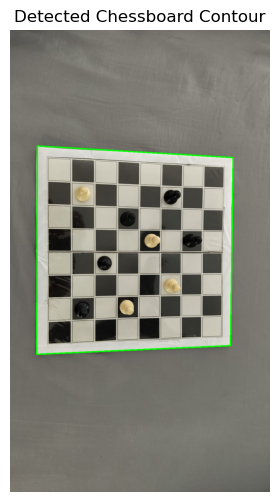

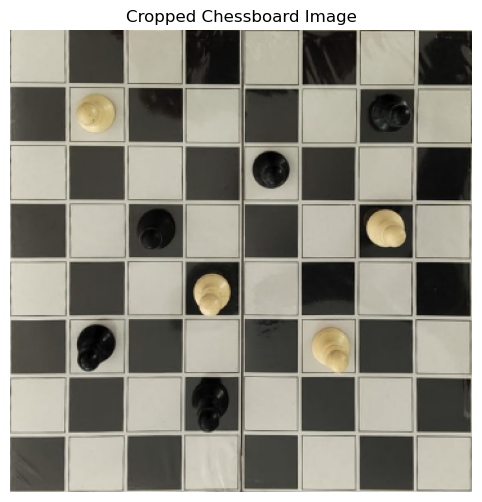

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to the image
image_path = "C:\\Users\\shrey\\Downloads\\final.jpg"

# Global variable to store the cropped image
global_cropped_image = None

def process_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to read the image file.")
        return None, None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return image, blurred

def detect_edges(blurred):
    if blurred is None:
        print("Error: Blurred image data is not valid.")
        return None
    blurred = np.uint8(blurred)
    edges = cv2.Canny(blurred, 50, 150)
    return edges

def find_contours(edges):
    if edges is None:
        print("Error: Edge detection failed.")
        return []
    kernel = np.ones((3,3), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def select_chessboard_contours(contours):
    largest_area = 0
    chessboard_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > largest_area:
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
            if len(approx) == 4:
                largest_area = area
                chessboard_contour = approx
    return chessboard_contour

def apply_projective_transform(image, chessboard_contour):
    pts1 = np.float32([chessboard_contour[0][0], chessboard_contour[1][0], chessboard_contour[2][0], chessboard_contour[3][0]])
    side_length = 400
    pts2 = np.float32([[0, 0], [side_length, 0], [side_length, side_length], [0, side_length]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(image, matrix, (side_length, side_length))
    return result

def crop_image(image, x, y, width, height):
    return image[y:y+height, x:x+width]

def main(image_path):
    global global_cropped_image  # Access the global variable
    image, blurred = process_image(image_path)
    if image is None or blurred is None:
        print("Preprocessing failed.")
        return
    
    edges = detect_edges(blurred)
    contours = find_contours(edges)
    chessboard_contour = select_chessboard_contours(contours)
    
    if chessboard_contour is not None:
        cv2.polylines(image, [chessboard_contour], True, (0, 255, 0), 3)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 6))
        plt.imshow(image_rgb)
        plt.title('Detected Chessboard Contour')
        plt.axis('off')
        plt.show()
        
        transformed_image = apply_projective_transform(image, chessboard_contour)
        
        if transformed_image is not None:
            x, y, width, height = 22, 22, 358, 358
            cropped_image = crop_image(transformed_image, x, y, width, height)
            
            global_cropped_image = cropped_image  # Save cropped image to global variable
            
            # Verify the global_cropped_image is valid
            if global_cropped_image is not None and isinstance(global_cropped_image, np.ndarray):
                cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(10, 6))
                plt.imshow(cropped_image_rgb)
                plt.title('Cropped Chessboard Image')
                plt.axis('off')
                plt.show()
            else:
                print("Error: global_cropped_image was not set correctly.")
        else:
            print("Transformation failed.")
    else:
        print("Chessboard not detected.")

main(image_path)


0: 640x640 (no detections), 95.6ms
Speed: 3.0ms preprocess, 95.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Running detection with confidence threshold of 0.5
0: 640x640 (no detections), 83.6ms
Speed: 3.0ms preprocess, 83.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 (no detections), 83.5ms
Speed: 4.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 (no detections), 84.4ms
Speed: 3.0ms preprocess, 84.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 83.0ms
Speed: 3.0ms preprocess, 83.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 100.7ms
Speed: 2.0ms preprocess, 100.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 88.4ms
Speed: 3.0ms preprocess, 88.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 85.0ms
Speed: 2.0ms preprocess, 85.0ms inference, 3.0ms postpro

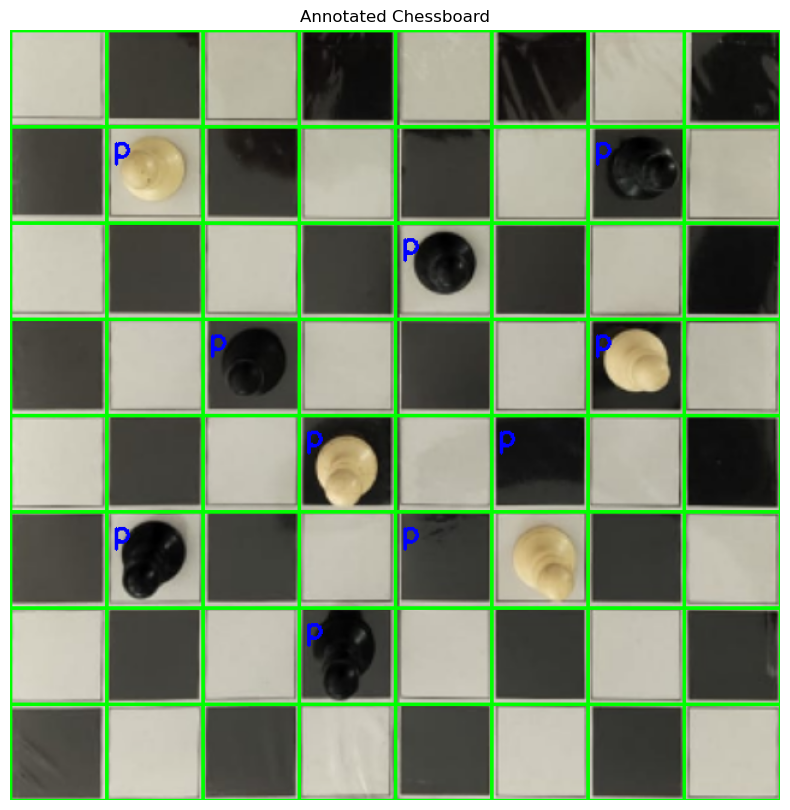

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import supervision as sv

# Load the YOLO model
model = YOLO("C:\\Users\\shrey\\Downloads\\best (1).pt")

# Class labels from the data.yaml
class_labels = ['black', 'white']

# Ensure global_cropped_image is available and is an image array
if global_cropped_image is None:
    print("Error: global_cropped_image is not initialized.")
else:
    # Resize global_cropped_image to 640x640 for YOLO model
    image = cv2.resize(global_cropped_image, (640, 640))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run inference on the image
    results = model(image_rgb)
    detections = sv.Detections.from_ultralytics(results[0])

    # Initialize board matrix
    board_matrix = [['0' for _ in range(8)] for _ in range(8)]
    tile_height = 640 // 8
    tile_width = 640 // 8

    # Debugging output
    print("Running detection with confidence threshold of 0.5")

    # Iterate over each tile
    for row in range(8):
        for col in range(8):
            x1, y1 = col * tile_width, row * tile_height
            x2, y2 = (col + 1) * tile_width, (row + 1) * tile_height
            tile = image[y1:y2, x1:x2]

            # Run inference on the tile
            tile_resized = cv2.resize(tile, (640, 640))
            tile_rgb = cv2.cvtColor(tile_resized, cv2.COLOR_BGR2RGB)
            tile_results = model(tile_rgb)
            tile_detections = sv.Detections.from_ultralytics(tile_results[0])

            # Apply confidence threshold and update board matrix
            detected = False
            for i, conf in enumerate(tile_detections.confidence):
                if conf >= 0.45:
                    class_id = tile_detections.class_id[i]
                    label = class_labels[class_id]
                    if label == 'white':
                        board_matrix[row][col] = 'P'
                    elif label == 'black':
                        board_matrix[row][col] = 'p'
                    detected = True
                    break  # Assuming only one detection per tile
            if not detected:
                board_matrix[row][col] = '0'

    # Convert board matrix to FEN notation
    fen_rows = []
    for row in board_matrix:
        empty_count = 0
        fen_row = ''
        for cell in row:
            if cell == '0':
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += cell
        if empty_count > 0:
            fen_row += str(empty_count)
        fen_rows.append(fen_row)

    fen_string = '/'.join(fen_rows)
    print("FEN notation:")
    print(fen_string)

    # Annotate the entire chessboard image
    annotated_frame = image.copy()
    for row in range(8):
        for col in range(8):
            x1, y1 = col * tile_width, row * tile_height
            x2, y2 = (col + 1) * tile_width, (row + 1) * tile_height
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            label = board_matrix[row][col]
            if label != '0':
                cv2.putText(annotated_frame, label, (x1 + 5, y1 + 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    # Display the annotated chessboard image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    plt.title('Annotated Chessboard')
    plt.axis('off')
    plt.show()


In [42]:
print(model.names)

{0: 'black', 1: 'white'}
